## Initial imports and load active learning job from disk

In [2]:
from scm.simple_active_learning import SimpleActiveLearningJob
import scm.plams as plams
import os
import matplotlib.pyplot as plt

In [1]:
plams.init()

PLAMS working folder: /home/hellstrom/adfhome/scripting/scm/params/examples/ActiveLearning/jupyter_notebooks/example1_molecule_2hydroxyethanal/plams_workdir.003


In [3]:
# replace the path with your own path !
previous_sal_job_path = os.path.expandvars("$AMSHOME/examples/SAL/Output/SingleMolecule/plams_workdir/sal")
sal_job = SimpleActiveLearningJob.load_external(previous_sal_job_path)
params_job = sal_job.results.get_params_job()

## Structure for production job

We could initialize a PLAMS molecule in many different ways. Here, we get the final frame from the final production simulation in the SAL job, and preoptimize it with UFF.

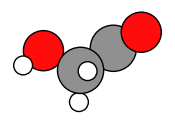

In [3]:
molecule = sal_job.results.get_main_molecule()
molecule = plams.preoptimize(molecule, model="UFF")
plams.plot_molecule(molecule)

## Settings for production job

Let's run a geometry optimization + frequencies. But you could run any AMS job!

The ``MaxRestarts`` option is useful when calculating normal modes. If the geometry optimizer converges to a transition state, it will continue until it finds a local minimum!

In [4]:
s = plams.Settings()
s.input.ams.Task = "GeometryOptimization"
s.input.ams.Properties.NormalModes = "Yes"
s.input.ams.GeometryOptimization.MaxRestarts = 5
s.runscript.nproc = 1

retrained_engine_settings = params_job.results.get_production_engine_settings()

new_job = plams.AMSJob(settings=s + retrained_engine_settings, name="retrained_m3gnet", molecule=molecule)
print(new_job.get_input())

GeometryOptimization
  MaxRestarts 5
End

Properties
  NormalModes Yes
End

Task GeometryOptimization

system
  Atoms
              O       1.7687383065       1.1638482324       0.1625808808 
              C       0.8505520934       0.6353737082      -0.4437015802 
              C      -0.2273678842      -0.0918083557       0.2943539891 
              O      -1.4487365506       0.5561008884       0.0797093813 
              H       0.8184659876       0.6935785078      -1.5266944395 
              H      -0.2816768047      -1.1351539858      -0.0862953199 
              H       0.0035728454      -0.1163549046       1.3835473650 
              H      -2.1178872806       0.0706066427       0.6290506419 
  End
  BondOrders
     1 2 2.0
     2 3 1.0
     2 5 1.0
     3 4 1.0
     3 6 1.0
     3 7 1.0
     4 8 1.0
  End
End

Engine MLPotential
  Backend M3GNet
  MLDistanceUnit angstrom
  MLEnergyUnit eV
  Model Custom
  ParameterDir /home/hellstrom/adfhome/scripting/scm/params/examples/SALOu

In [5]:
new_job.run();

[02.02|12:39:32] JOB retrained_m3gnet STARTED
[02.02|12:39:32] JOB retrained_m3gnet RUNNING
[02.02|12:39:47] JOB retrained_m3gnet FINISHED
[02.02|12:39:47] JOB retrained_m3gnet SUCCESSFUL


### Optimized structure

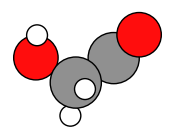

In [6]:
plams.plot_molecule(new_job.results.get_main_molecule())

### Frequencies

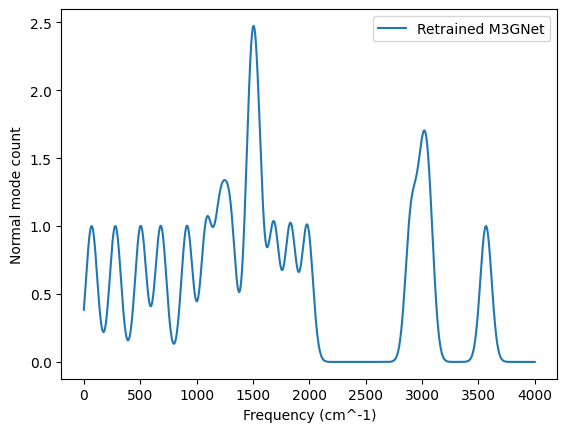

In [7]:
width = 50  # cm^-1
x, y = new_job.results.get_ir_spectrum(broadening_width=width, post_process="all_intensities_to_1")
plt.plot(x, y, label="Retrained M3GNet")
plt.xlabel("Frequency (cm^-1)")
plt.ylabel("Normal mode count")
plt.legend();

## Compare to reference UFF
In this case, we can also calculate the normal modes with the reference method (UFF) and compare:

In [8]:
ref_engine_settings = plams.Settings()
ref_engine_settings.input.ForceField.Type = "UFF"
ref_job = plams.AMSJob(settings=s + ref_engine_settings, name="uff_ref", molecule=molecule)
ref_job.run();

[02.02|12:39:48] JOB uff_ref STARTED
[02.02|12:39:48] JOB uff_ref RUNNING
[02.02|12:39:48] JOB uff_ref FINISHED
[02.02|12:39:48] JOB uff_ref SUCCESSFUL


In [9]:
retrained_structure_rmsd = plams.Molecule.rmsd(
    ref_job.results.get_main_molecule(),
    new_job.results.get_main_molecule(),
    ignore_hydrogen=True,
)
print(f"Structural RMSD: {retrained_structure_rmsd:.2f} angstrom")

Structural RMSD: 0.10 angstrom


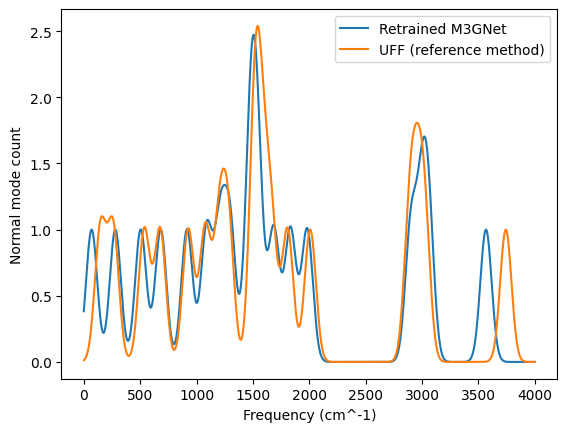

In [10]:
x_ref, y_ref = ref_job.results.get_ir_spectrum(broadening_width=width, post_process="all_intensities_to_1")
plt.plot(x, y, label="Retrained M3GNet")
plt.plot(x_ref, y_ref, label="UFF (reference method)")
plt.xlabel("Frequency (cm^-1)")
plt.ylabel("Normal mode count")
plt.legend();

The agreement looks very good! The only significant difference is the highest-frequency vibration (the O-H streching vibration). This frequency is very sensitive to the calculated forces near the equilibrium (minimum) structure. The agreement could have been improved by

* having more training data, for example by setting a tighter success criterion for the forces and energy in the active learning
* running the active learning MD at a lower temperature (closer to the equilibrium structure, but this would mean less conformational sampling)
* training for more epochs

Tip: check if the vibrational frequencies with retrained M3GNet or M3GNet-UP-2022 agree better or worse with the reference UFF calculation.